### Offense-Defense Custom Rating 2018

#### Libraries

In [2]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)
library(tidyimpute,warn.conflicts=F)

library(psych,warn.conflicts=F)
library(ggplot2,warn.conflicts=F)

#### Load 2018

In [3]:
# load the stats
data.regulars <- readRDS('../datafiles_rds/RegularSeasonDetailedResults.rds')
# keep 2018
data.regulars %>% filter(Season==2018) -> data.regulars

In [4]:
# load the stats
data.teams <- readRDS('../datafiles_rds/Teams.rds')

data.teams %>%
    select(TeamID,TeamName) %>%
    mutate(TeamName=str_to_lower(TeamName), 
           TeamName=str_replace_all(TeamName,' ','_'), 
           TeamName=str_remove_all(TeamName,'&')) -> df.teams

#### Prepare data

In [5]:
data.regulars %>% dim %>% cat
data.regulars %>% head

5405 34

Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,⋯,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2018,11,1104,82,1272,70,N,0,26,57,⋯,17,22,36,19,24,7,17,7,3,22
2018,11,1107,69,1233,67,H,0,24,62,⋯,22,11,14,7,20,14,7,6,3,21
2018,11,1112,101,1319,67,H,0,34,57,⋯,13,17,30,12,11,11,13,3,1,24
2018,11,1113,94,1226,74,H,0,34,65,⋯,24,13,22,8,21,17,14,6,2,20
2018,11,1116,95,1359,56,H,0,36,63,⋯,29,8,15,15,17,12,19,6,1,20
2018,11,1120,102,1313,74,H,0,35,63,⋯,34,20,27,9,20,15,16,11,3,26


In [6]:
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_replace(.,'L','O'))) %>%
    rename_at(vars(starts_with('W')),list(~str_remove(.,'W'))) %>%
    mutate(OLoc=case_when(Loc=='H' ~ 'A', Loc=='A' ~ 'H', TRUE ~ 'N')) -> group1
data.regulars %>% 
    rename_at(vars(starts_with('L')),list(~str_remove(.,'L'))) %>%
    rename_at(vars(starts_with('W')),list(~str_replace(.,'W','O'))) %>%
    mutate(Loc=case_when(OLoc=='H' ~ 'A', OLoc=='A' ~ 'H', TRUE ~ 'N')) -> group2
group1 %>% bind_rows(group2) -> df.regulars

In [7]:
df.regulars %>% dim %>% cat('\n')
df.regulars %>% arrange(Season,DayNum) %>% head

10810 35 


Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,OLoc
2018,11,1104,82,1272,70,N,0,26,57,⋯,22,36,19,24,7,17,7,3,22,N
2018,11,1107,69,1233,67,H,0,24,62,⋯,11,14,7,20,14,7,6,3,21,A
2018,11,1112,101,1319,67,H,0,34,57,⋯,17,30,12,11,11,13,3,1,24,A
2018,11,1113,94,1226,74,H,0,34,65,⋯,13,22,8,21,17,14,6,2,20,A
2018,11,1116,95,1359,56,H,0,36,63,⋯,8,15,15,17,12,19,6,1,20,A
2018,11,1120,102,1313,74,H,0,35,63,⋯,20,27,9,20,15,16,11,3,26,A


In [8]:
df.regulars %>%
    left_join(df.teams %>% rename(OTeamName=TeamName),by=c('OTeamID'='TeamID')) %>%
    left_join(df.teams,by='TeamID') -> df.regulars

#### Stat matrix

In [9]:
CreateMatrix <- function(dataset,stat) {
    stat_var <- enquo(stat)
    dataset %>% rename(Statistic := !!stat_var) -> dataset
    for(i in 2018:2018) {
        dataset %>%
            filter(Season==i) %>%
            select(TeamName,OTeamName,Statistic) %>% 
            group_by(TeamName,OTeamName) %>% 
            summarise(Statistic=mean(Statistic)) %>% 
            ungroup() %>%
            spread(TeamName,Statistic) %>% 
            impute(0.01) %>% 
            select(-OTeamName) %>% 
            as.matrix() -> tmp
        dataset %>% 
            filter(Season==i) %>% 
            distinct(OTeamName) %>% 
            arrange(OTeamName) %>% 
            pull(OTeamName) -> vnames
        attr(tmp,'dimnames') <- list(vnames,vnames)
        assign(paste0('m.stat.',i), tmp, envir=.GlobalEnv)
    }
}

In [10]:
dataset <- df.regulars %>% 
    mutate(Poss=FGA+0.475*FTA-OR+TO,ScorePoss=Score/Poss) %>%
    mutate(OPoss=OFGA+0.475*OFTA-OOR+OTO,OScorePoss=OScore/OPoss) %>%
    mutate(GmS=(ScorePoss+1)/(ScorePoss+OScorePoss+2))

In [11]:
dataset %>% head

Season,DayNum,TeamID,Score,OTeamID,OScore,Loc,NumOT,FGM,FGA,⋯,OBlk,OPF,OLoc,OTeamName,TeamName,Poss,ScorePoss,OPoss,OScorePoss,GmS
2018,11,1104,82,1272,70,N,0,26,57,⋯,3,22,N,memphis,alabama,73.300,1.118690,75.100,0.9320905,0.5230326
2018,11,1107,69,1233,67,H,0,24,62,⋯,3,21,A,iona,albany_ny,65.025,1.061130,65.650,1.0205636,0.5049694
2018,11,1112,101,1319,67,H,0,34,57,⋯,1,24,A,northern_arizona,arizona,71.200,1.418539,73.250,0.9146758,0.5581397
2018,11,1113,94,1226,74,H,0,34,65,⋯,2,20,A,idaho_st,arizona_st,76.350,1.231172,75.450,0.9807820,0.5297238
2018,11,1116,95,1359,56,H,0,36,63,⋯,1,20,A,samford,arkansas,77.450,1.226598,72.125,0.7764298,0.5562284
2018,11,1120,102,1313,74,H,0,35,63,⋯,3,26,A,norfolk_st,auburn,84.250,1.210682,80.825,0.9155583,0.5357619


In [12]:
CreateMatrix(dataset,GmS)

####  Offense-Defense Rating

In [13]:
ComputeRating <- function(A) {
    dnow <- rep(1,nrow(A))
    for(i in 1:100) {
        dprev <- dnow
        dnow <- A %*% (1/(t(A) %*% (1/dprev)))
    }
    rdef <- as.vector(dnow)
    roff <- as.vector(t(A) %*% (1/rdef))
    rating <- as.vector(roff / rdef)
    data.frame(Team=attr(A,'dimnames')[[2]],Rating=rating,Offense=roff,Defense=rdef)
}

In [14]:
ComputeRating(m.stat.2018) %>% 
    mutate(Season=2018) %>% 
    mutate_if(is.factor,as.character) -> df.ratings

In [15]:
df.ratings %>% arrange(desc(Rating)) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% select(Season,everything())

Season,Team,Rating,Offense,Defense
2018,virginia,16.03642,16.38571,1.021781


###  Regular seasons performance (train dataset)

In [16]:
data.regulars %>% 
    select(Season,WTeamID,LTeamID) %>%
    mutate(TeamID.x = ifelse(WTeamID<LTeamID,WTeamID,LTeamID), 
           TeamID.y = ifelse(WTeamID<LTeamID,LTeamID,WTeamID),
           Target = ifelse(TeamID.x==WTeamID,1,0),
           ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>%
    select(-WTeamID,-LTeamID) -> df.train

In [17]:
df.ratings %>%
    left_join(df.teams,by=c('Team'='TeamName')) -> df.ratings

In [18]:
df.train %>%
    select(-Target,-ID) %>%
    inner_join(df.ratings,by=c('Season','TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team) %>%
    inner_join(df.ratings,by=c('Season','TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> data.train.matchups

In [19]:
data.train.matchups %>% sample_n(5)

Season,TeamID.x,TeamID.y,Rating.x,Rating.y
2018,1192,1291,13.53093,13.67047
2018,1245,1290,13.89913,12.66353
2018,1178,1464,13.40177,13.24373
2018,1202,1422,14.55420,14.63041
2018,1194,1296,13.64979,13.71278


In [20]:
# slope hyper parameter grid : we will compute 80 models and chose the best one (min logloss)
df.ratings %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.80,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(Season,qtl) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.slopes
df.slopes %>% sample_n(5)

Season,qtl,Slope
2018,0.15,1.172652
2018,0.18,1.197999
2018,0.14,1.159917
2018,0.79,2.300200
2018,0.31,1.324320


In [21]:
data.train.matchups %>% 
    inner_join(df.slopes,by=c('Season')) -> data.train.matchups
data.train.matchups %>% dim %>% cat('\n')
data.train.matchups %>% sample_n(5)

432400 7 


Season,TeamID.x,TeamID.y,Rating.x,Rating.y,qtl,Slope
2018,1110,1131,13.28020,13.71960,0.26,1.264607
2018,1202,1354,14.55420,13.00245,0.76,2.206172
2018,1252,1312,14.06396,13.82812,0.59,1.695790
2018,1422,1459,14.63041,14.12085,0.47,1.512124
2018,1102,1429,13.67905,14.25000,0.19,1.204735


In [22]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
data.train.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(Season,qtl,ID,Pred,Prob) -> df.train.submit
df.train.submit %>% sample_n(5)

Season,qtl,ID,Pred,Prob
2018,0.05,2018_1124_1403,0,0.351
2018,0.12,2018_1279_1397,0,0.280
2018,0.23,2018_1209_1279,1,0.511
2018,0.28,2018_1185_1316,1,0.718
2018,0.56,2018_1148_1187,1,0.550


In [23]:
# merge prediction and truth
df.train %>% select(ID,Target) -> data.train.truth
data.train.truth %>% inner_join(df.train.submit,by='ID') -> df.train.results

In [24]:
# compute accuracy & Logloss per qtl to find the best one per Season
df.train.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(Season,qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(Season,qtl,TC,FC,N,Acc,LogLoss) -> df.train.perf
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() 

Season,qtl,TC,FC,N,Acc,LogLoss
2018,0.72,6505,2508,9013,0.7217353,0.5317344


In [25]:
df.train.perf %>% distinct(Season,Acc) %>% spread(Season,Acc,sep='_') %>%
    mutate(Stat='Accuracy') %>% select(Stat,everything()) -> tmp01
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,LogLoss) %>% spread(Season,LogLoss,sep='_') %>% mutate(Stat='Best LogLoss') %>% select(Stat,everything()) -> tmp02
df.train.perf %>% arrange(LogLoss) %>% group_by(Season) %>% slice(1:1) %>% ungroup() %>% 
    select(Season,qtl) %>% spread(Season,qtl,sep='_') %>% mutate(Stat='Best Quantile') %>% select(Stat,everything()) -> tmp03
tmp01 %>% bind_rows(tmp02) %>% bind_rows(tmp03)

Stat,Season_2018
Accuracy,0.7217353
Best LogLoss,0.5317344
Best Quantile,0.7200000


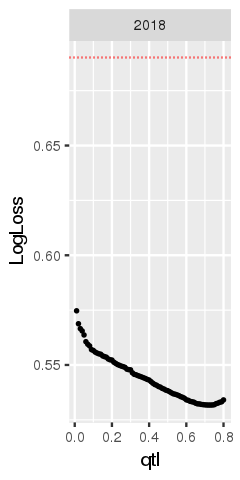

In [26]:
options(repr.plot.width=2, repr.plot.height=4)
ggplot(data=df.train.perf,aes(x=qtl,y=LogLoss)) + 
    geom_point(size=0.5) + 
    geom_hline(yintercept=0.69,color='red',linetype="dotted") +
    facet_grid(. ~ Season)

### Tourney matchups performance (validation dataset)

#### Load test data

In [27]:
data.matchups <- readRDS('../datafiles_rds/TourneyMatchups.rds')
data.matchups %>%
    filter(Season==2018) -> data.matchups

#### prepare

In [28]:
data.matchups %>%
    select(-Season) %>%
    inner_join(df.ratings,by=c('TeamID.x'='TeamID')) %>%
    select(-Offense,-Defense,-Team,-Season) %>%
    inner_join(df.ratings,by=c('TeamID.y'='TeamID')) %>% 
    select(-Offense,-Defense,-Team) -> df.matchups  

In [29]:
df.matchups %>% head

TeamID.x,TeamID.y,Rating.x,Rating.y,Season
1347,1382,14.11569,14.94652,2018
1347,1393,14.11569,15.03618,2018
1347,1411,14.11569,13.67137,2018
1347,1348,14.11569,15.06638,2018
1347,1371,14.11569,15.13866,2018
1347,1397,14.11569,15.31907,2018


In [30]:
df.slopes %>% filter(qtl==0.72) %>% pull(Slope) -> Slope

In [31]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,Pred,Prob) -> df.submit
df.submit %>% arrange(ID) %>% head

ID,Pred,Prob
2018_1104_1112,0,0.243
2018_1104_1113,0,0.278
2018_1104_1116,0,0.359
2018_1104_1120,0,0.273
2018_1104_1137,1,0.648
2018_1104_1138,1,0.537


#### Performance

In [32]:
data.truth <- readRDS('../datafiles_rds/TourneyTrueResults.rds')

In [33]:
df.submit %>%
    inner_join(data.truth,by='ID') %>%
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(TC,FC,N,Acc,LogLoss) -> df.test.perf
df.test.perf %>% arrange(LogLoss) %>% slice(1:1)

TC,FC,N,Acc,LogLoss
47,20,67,0.7014925,0.5843792


In [34]:
df.submit %>% head

ID,Pred,Prob
2018_1347_1382,0,0.157
2018_1347_1393,0,0.134
2018_1347_1411,1,0.711
2018_1347_1348,0,0.127
2018_1347_1371,0,0.112
2018_1347_1397,0,0.081


In [35]:
saveRDS(df.submit,'../predictions/OffDeff_2018.rds')